In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from helper import groupby_consecutive

import sys

sys.path.append("..")
from plotly_resampler import FigureResampler, FigureWidgetResampler, EveryNthPoint
from plotly_resampler.aggregation import NoGapHandler, MedDiffGapHandler
from plotly_resampler.aggregation import MinMaxLTTB


USE_PNG = True  # Set to false to use dynamic plots

# Adding dynamic aggregation to your plotly Figure


In [3]:
# Some dummy data that will be used throughout the examples
n = 2_000_000
x = np.arange(n)
x_time = pd.date_range("2020-01-01", freq="1s", periods=len(x))
noisy_sine = (3 + np.sin(x / 2000) + np.random.randn(n) / 10) * x / (n / 4)

## **auto mode**: `register_plotly_resampler`


Once `register_plotly_resampler` method is called, it will automatically convert all new defined plotly graph objects into a `FigureResampler` or `FigureWidgetResampler` object. The `mode` parameter of this method allows to define which type of the aforementioned resampling objects is used.

✅ **advantages**:

-   This is the most convenient way to make your existing codebase more scalable
-   You can keep on using your regular graph construction code

❌ **disadvantages**:

-   all figures will be wrapped with plotly-resampler behavior (less control)
-   if you want to go the extra mile regarding graph construction performance, it is better to use the `FigureResampler` or `FigureWidgetResampler` components individually.


In [4]:
from plotly_resampler import register_plotly_resampler, unregister_plotly_resampler

In [5]:
# by default, 1,000 samples per trace are shown
register_plotly_resampler(mode="auto", default_n_shown_samples=4500)

In [6]:
# auto mode: when working in an IPython environment, this will automatically be a
# FigureWidgetResampler else, this will be an FigureResampler
fig = go.Figure()
fig.add_traces(
    [
        {"y": noisy_sine + 2, "name": "yp2", "type": "scattergl"},
        {"y": noisy_sine - 3, "name": "ym1", "type": "scatter"},
    ]
)
print(type(fig))
display(fig)

<class 'plotly_resampler.figure_resampler.figurewidget_resampler.FigureWidgetResampler'>


FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> yp2 <i style="color:#fc9944">~444</i>',
              'type': 'scattergl',
              'uid': '3929a25d-3337-4b0d-9c9d-013c5012c0e4',
              'x': array([      0,     224,     862, ..., 1999067, 1999437, 1999999], dtype=uint64),
              'y': array([ 2.        ,  2.00132823,  2.00643358, ..., 16.77748749, 15.5656692 ,
                          17.28300882])},
             {'name': '<b style="color:sandybrown">[R]</b> ym1 <i style="color:#fc9944">~444</i>',
              'type': 'scatter',
              'uid': '0e5af0c8-c96a-404c-9e23-8fe650e14cc0',
              'x': array([      0,     224,     862, ..., 1999067, 1999437, 1999999], dtype=uint64),
              'y': array([-3.        , -2.99867177, -2.99356642, ..., 11.77748749, 10.5656692 ,
                          12.28300882])}],
    'layout': {'template': '...'}
})

❗ `.show()` always returns a static html view


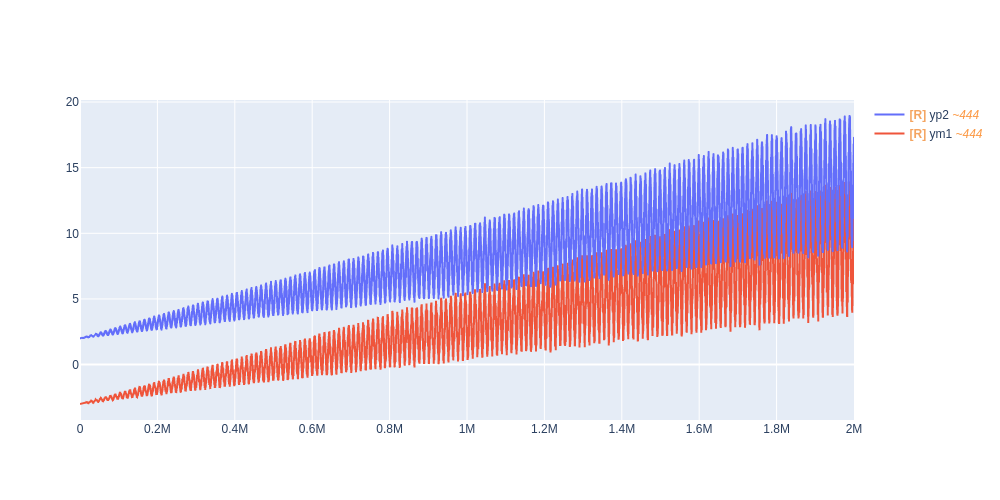

In [7]:
# this outputs a static html view of the figure, which can be serialized within notebooks
if USE_PNG:
    unregister_plotly_resampler()
    go.Figure(fig).show(renderer="png", width=1000, height=500)
else:
    fig.show()

### pro tip: `register_plotly_resampler` + pandas plotting backend = 🔥


The combo below allows to conveniently visualize large time_series data


In [8]:
register_plotly_resampler(mode="auto", default_n_shown_samples=1500)
# pd.options.plotting.backend = 'plotly'  # sets plotly(-resampler) as default plotting backend

In [9]:
df = pd.DataFrame(data={"sine": noisy_sine, "neg-sine": -noisy_sine}, copy=False)
df

,sine,neg-sine
0,0.000000,-0.000000
1,0.000006,-0.000006
2,0.000012,-0.000012
3,0.000018,-0.000018
4,0.000024,-0.000024
...,...,...
1999995,14.998186,-14.998186
1999996,15.841833,-15.841833
1999997,15.477623,-15.477623
1999998,14.948636,-14.948636


In [10]:
# use datetime index
df.index = pd.date_range(start="2020-01-01", periods=len(df), freq="1s")

In [11]:
df.plot(backend="plotly")

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=sine<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'sine',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> sine <i style="color:#fc9944">~22m</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '1eb2a7e5-7962-47aa-a7ee-7c2d4977e864',
              'x': array([datetime.datetime(2020, 1, 1, 0, 0),
                          datetime.datetime(2020, 1, 1, 0, 11, 18),
                          datetime.datetime(2020, 1, 1, 0, 43, 54), ...,
                          datetime.datetime(2020, 1, 24, 2, 48, 24),
                          datetime.datetime(2020, 1, 24, 3, 11, 52),
                          datetime.datetime(2020, 1, 24, 3, 33, 19)], dtype=object),
              'xaxis': 'x',
              'y': array(

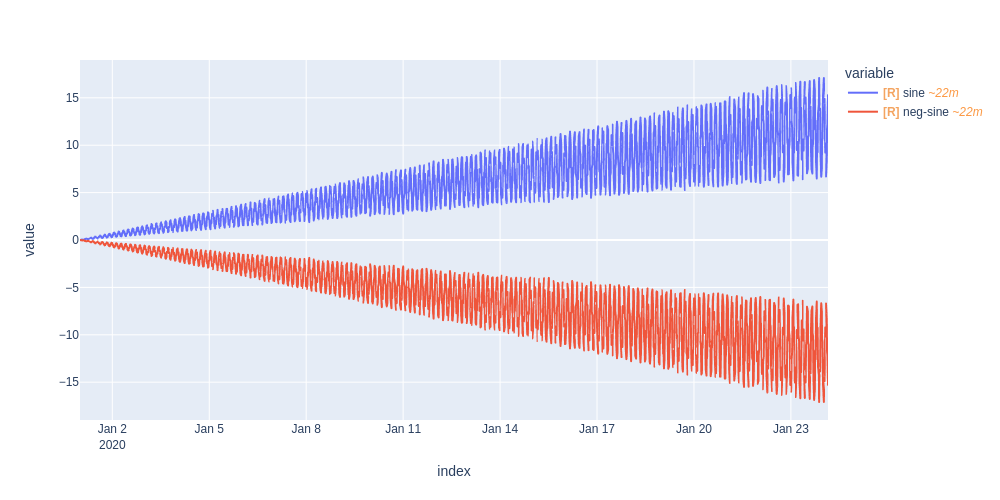

In [12]:
if USE_PNG:
    fig = df.plot(backend="plotly")
    unregister_plotly_resampler()
    go.Figure(fig).show(renderer="png", width=1000, height=500)
unregister_plotly_resampler()

## **manual mode**: Basic sine example


✅ **advantages**:

-   Highly configurable (e.g., downsampler per trace, number of shown sample per trace)
-   Most optimizable (by leveraging the `hf_` arguments)

❌ **disadvantages**:

-   more tedious (more code needs to be written)

This example shows how the `FigureResampler` can be used to efficiently construct a graph


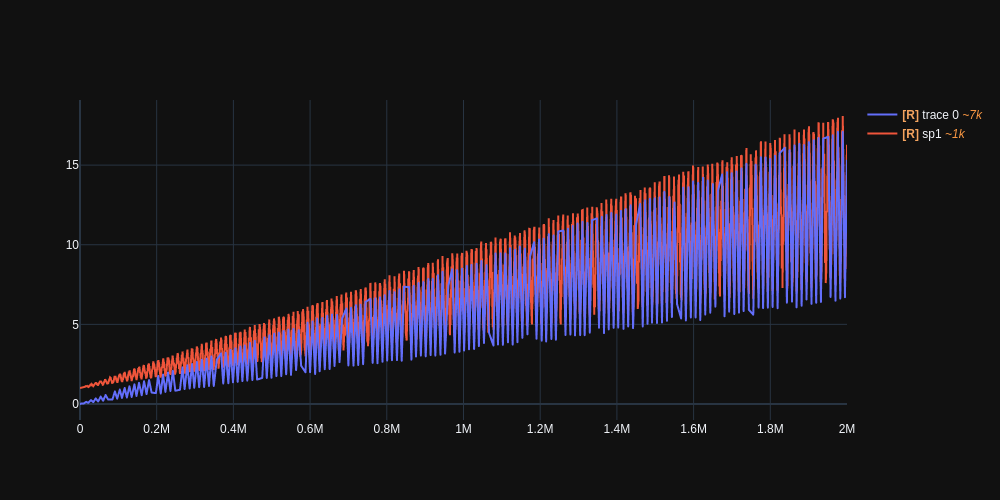

In [13]:
# 1. Wrap the figure with the FigureResampler class
fig = FigureResampler(go.Figure())

# Add the trace using the `hf_x` & `hf_y` for faster rendering
# (this does not impact the resampling speed once rendered)
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=300)
# Note how a dict input is also valid and how different # of samples per trace are used
fig.add_trace(dict(x=x, y=noisy_sine + 1, name="sp1"), max_n_samples=2000)

# Optional: update the layout
fig.update_layout(height=400, template="plotly_dark")

# 2. Call show_dash
fig.show_dash(mode="inline")
if USE_PNG:
    fig.show(renderer="png", width=1000, height=500)

For the `FigureWidgetResampler` use case, you only need to change way of displaying the figure


In [14]:
# Same content as above, but using the FigureWidgetResampler class
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=200)
fig.add_trace(dict(x=x, y=noisy_sine + 1, name="sp1"), max_n_samples=2000)
fig.update_layout(height=400, template="plotly_dark")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
display(fig)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc9944">~10k</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '77ff99d6-2674-4fd6-82fa-93e6df9cce11',
              'x': array([      0,    8614,   16467,   21308,   40000,   47288,   53829,   60208,
                            78405,   84624,   91017,  109361,  116502,  122232,  130156,  147263,
                           153868,  160848,  178995,  185645,  191156,  209818,  217152,  223631,
                           230048,  248589,  254280,  267436,  272744,  292170,  297878,  304890,
                           317660,  323659,  342631,  348832,  355259,  367841,  373521,  389923,
                           398873,  405236,  415113,  430910,  436223,  443353,  461773,  467907,
                           474140,  487020,  493564,  512090,  518531,  525117,  543372,  549383,
                           556503,  574722,  581430,  587

In [15]:
# Same content as above, but using the FigureWidgetResampler class
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=900)
fig.update_layout(height=400, template="plotly_dark")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
display(fig)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc9944">~2k</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '130b2e59-a035-4381-934c-c553145011d2',
              'x': array([      0,    1130,    4441, ..., 1996714, 1998815, 1999999]),
              'y': array([0.00000000e+00, 7.44078359e-03, 3.57661955e-02, ..., 8.40733518e+00,
                          1.46282969e+01, 1.52830088e+01])}],
    'layout': {'height': 400, 'template': '...'}
})

## **autosize**: Dash Figures that scale automatically to webpage size


Demo:<br>

---

![](https://user-images.githubusercontent.com/38005924/277514823-72551f7f-5005-4581-aca2-5dc20fdf31f1.gif)

---


All you need to do is:

-   set the `autosize` layout argument of the `FigureResampler` object to `True` (and not specify any height or width)
-   call `show_dash` with `mode=external` (or use `register_plotly_resampler` with `mode=external`)


In [16]:
# Construct a FigureResampler instance and a trace to the figure
fig = FigureResampler()
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=900)

# Set the autosize property to True (and do not specify a height or width)
fig.update_layout(
    autosize=True, legend=dict(orientation="h", xanchor="right", x=1, y=1.05)
)
# Call show dash with mode="external"
fig.show_dash(mode="external", port=8055)

Dash app running on http://127.0.0.1:8055/


# Advanced stuff


## `plotly-resampler` notebook figure retention|serialization


It is often useful to still retain a figure after your notebook is disconnected from your python kernel, e.g., when exported to html.

To this end, the `"inline_persistent"` argument was added to the `FigureResampler.show_dash` which outputs a static image (of the global aggregated view) when the kernel is disconnected.<br>
The example below illustrates this behavior

> **Note**:
>
> -   you must have `kaleido`, `flask-cors` and `jupyter-dash` installed for this to work.
> -   The static output figure will only be shown in environments where javascript code is allowed to execute.


<details> <summary><b>How is this implemented?</b></summary>
We create a JupyterDash subclass which extends the "inline" visualization capabilities with the functionality described above.<br>
This extension is triggered when <i>"inline_persistent"</i> is used in the <code>FigureResampler.show_dash</code> method.<br>

<ul>
    <li>we add a unique _uid to each object</li>
    <li>we add a new endpoint to the underlying flask app that</li><ul>
        <li>is only accessible via the corresponding app its _uid</li>
        <li>has CORS rights for any origin and 'Content-Type' headers</li>
        </ul>
        <li>Note that this is the only CORS endpoint of the JupyterDash app & is only preset when "inline_persistent" is used!</li>
    <li>we check in the JavaScript output of the notebook cell whether that endpoint is reachable and emits the expected message (i.e., "Alive")</li><ul>
        <li>if check is successful => display an iframe of the running Jupyter dash app</li>
        <li>if check is not successful => display a static image</li>
    </ul>
</ul>
</details>
<details> <summary><b>How does this work?</b></summary>
    Some additional JavaScript code is added to the <code>IPython.display.display</code> method, which contains a <i>base64</i> bytarray image of the shown figure.<br>
    When the dash app is not reachable, the image is shown instead of the iframe (which embedded the connected dash app).<br>
    This works because the JavaScript in the notebook output cells gets executed each time a notebook is loaded (❗the kernel should not be running for this to happen).
</details>


In [17]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=900)
fig.update_layout(height=400, template="plotly_white")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
fig.show_dash(mode="inline_persistent")

When you:

-   restart the kernel; and reopen this notebook
-   export this notebook to html

you should see a static (aggregated) image of the above figure


## x-axis overview (rangeslider)


The default rangeslider functionality does not tend to work with plotly-resampler.
As such, we created a custom rangeslider solution which is compatible with plotly-resampler.
This component can be used by setting the `xaxis_overview` argument to `True` in the `FigureResampler` constructor.

> **Note**:
>
> -   This component is only available for `FigureResampler` objects
> -   The `overview_row_idxs` argument can be used to specify which rows of each subplot column should be shown in the overview.<br>This row index starts at 0.
> -   This is functionality not extensively validated yet, so please report any issues you encounter!


In [18]:
fig: FigureResampler = FigureResampler(
    make_subplots(rows=2, cols=2, shared_xaxes="columns", horizontal_spacing=0.03),
    default_downsampler=MinMaxLTTB(parallel=True),
    # Enable the overview axis
    create_overview=True,
    # Specify the subplot rows that will be used for the overview axis of each column
    overview_row_idxs=[1, 0],
    # Additonal kwargs for the overview axis
    overview_kwargs={"height": 100},
)

# Figure construction logic
# fmt: off
log = noisy_sine * 0.9999995**x
exp = noisy_sine * 1.000002**x
fig.add_trace(go.Scattergl(name="log", legend='legend1'), hf_x=x, hf_y=log)
fig.add_trace(go.Scattergl(name="exp", legend='legend1'), hf_x=x, hf_y=exp)

fig.add_trace(go.Scattergl(name="-log", legend='legend2'), hf_x=x, hf_y=-exp, row=1, col=2)

fig.add_trace(go.Scattergl(name="log", legend='legend3'), hf_x=x, hf_y=-log, row=2, col=1)
fig.add_trace(go.Scattergl(name="3-exp", legend='legend3'), hf_x=x, hf_y=3 - exp, row=2, col=1)

fig.add_trace(go.Scattergl(name="log", legend='legend4'), hf_x=x, hf_y=log**2, row=2, col=2)

# fmt: on
fig.update_layout(
    # NOTE: we can specify how each legend is positioned
    # (i.e., above the corresponding subplot)
    legend1=dict(orientation="h", yanchor="bottom", y=1.02),
    legend2=dict(orientation="h", yanchor="bottom", y=1.02, x=0.52),
    legend3=dict(orientation="h", y=0.51, x=0),
    legend4=dict(orientation="h", y=0.51, x=0.52),
)
fig.update_layout(margin=dict(b=15), template="plotly_white")
fig.show_dash(mode="inline", port=8004)

## Setting Marker Size and Color


The snippet below utilizes the `FigureResampler.add_trace` its `hf_marker_size` and `hf_marker_color` arguments to set the marker size and color of the traces.

Noteworthy things about [markers](https://plotly.com/python-api-reference/generated/plotly.graph_objects.scatter.marker.html)

-   The marker range can be set as well via the `marker_cmin` and `marker_cmax` arguments<br>
    By setting the marker color scale range, we can ensure that the color scale consistency (as the color-range would otherwise be computed on the aggregated data range)
-   Markers are more complex JavaScript objects and take significantly longer to (re)render than lines. As such; you should only use (styled) markers when necessary.


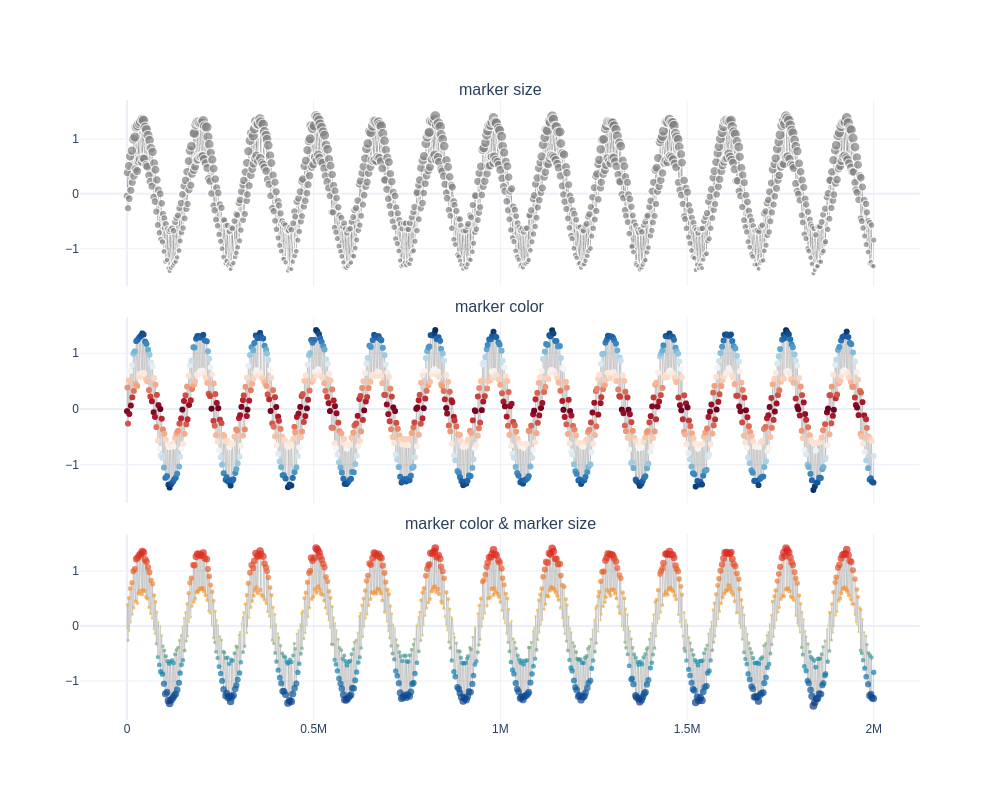

Dash app running on http://127.0.0.1:9032/


In [19]:
# stationary_sine = (np.sin(x / 2000) + np.random.randn(n) / 10) * x / (n / 8)
stationary_sine = np.sin(x / 25_000) + np.random.randn(x.shape[0]) / 10
fig = FigureResampler(
    make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        subplot_titles=["marker size", "marker color", "marker color & marker size"],
        vertical_spacing=0.05,
    )
)

shared_kwargs = dict(
    mode="lines+markers", showlegend=False, line_width=0.3, line_color="gray"
)

fig.add_trace(
    go.Scattergl(**shared_kwargs),
    hf_x=x,
    hf_y=stationary_sine,
    hf_marker_size=2 + 2 * (3 + stationary_sine),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        **shared_kwargs,
        marker_size=6,
        marker_colorscale="rdbu",  # also set the marker color scale
        # NOTE: by setting the marker color scale range, we can ensure that the color
        #       scale consistency (as the color-range would otherwise be computed
        #       on the aggregated data range)
        marker_cmin=0,
        marker_cmax=max(stationary_sine),
    ),
    hf_x=x,
    hf_y=stationary_sine,
    hf_marker_color=np.abs(stationary_sine),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        **shared_kwargs,
        marker_size=6,
        marker_colorscale="portland",
        marker_cmin=min(stationary_sine),
        marker_cmax=max(stationary_sine),
        marker_line_width=0,
    ),
    hf_x=x,
    hf_y=stationary_sine,
    hf_marker_color=stationary_sine,
    hf_marker_size=2 + 4 * np.abs(stationary_sine),
    row=3,
    col=1,
)

fig.update_layout(height=800, template="plotly_white")

# Displaying the figure -> instead of `show_dash`, use IPython's `display`
if USE_PNG:
    fig.show(renderer="png", width=1000, height=800)

fig.show_dash(mode="external", port=9032)

## Adjusting the data of your plotly-resampler figure at runtime


The `hf_data` property of the `FigureResampler` / `FigureWidgetResampler` can be used to change figure data at runtime


### `FigureResampler`


In [20]:
fig = FigureResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True, name="noisy_sine"), hf_y=noisy_sine)
display(fig.hf_data)
fig.show_dash(mode="inline")

[{'max_n_samples': 1000,
  'default_n_samples': True,
  'name': 'noisy_sine',
  'axis_type': 'linear',
  'downsampler': <plotly_resampler.aggregation.aggregators.MinMaxLTTB at 0x7fe257af4ac0>,
  'default_downsampler': True,
  'gap_handler': <plotly_resampler.aggregation.gap_handlers.MedDiffGapHandler at 0x7fe256694a30>,
  'default_gap_handler': True,
  'x': RangeIndex(start=0, stop=2000000, step=1),
  'y': array([0.00000000e+00, 6.00721317e-06, 1.20661988e-05, ...,
         1.54776225e+01, 1.49486363e+01, 1.52830088e+01]),
  'text': None,
  'hovertext': None,
  'marker_size': None,
  'marker_color': None,
  'customdata': None}]

Now we adjust the figure data  
**Note**: after running the cell below, we need to manually trigger a graph update (by for example zooming / resetting the axes) to ensure that the new data is shown.


In [21]:
fig.hf_data[0]["y"] = 10 * noisy_sine
# make sure to interact win the figure to see the change

### `FigureWidgetResampler`


In [22]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(showlegend=True, name="noisy_sine"), hf_y=noisy_sine)
display(fig.hf_data)
display(fig)

[{'max_n_samples': 1000,
  'default_n_samples': True,
  'name': 'noisy_sine',
  'axis_type': 'linear',
  'downsampler': <plotly_resampler.aggregation.aggregators.MinMaxLTTB at 0x7fe256696590>,
  'default_downsampler': True,
  'gap_handler': <plotly_resampler.aggregation.gap_handlers.MedDiffGapHandler at 0x7fe2566968f0>,
  'default_gap_handler': True,
  'x': RangeIndex(start=0, stop=2000000, step=1),
  'y': array([0.00000000e+00, 6.00721317e-06, 1.20661988e-05, ...,
         1.54776225e+01, 1.49486363e+01, 1.52830088e+01]),
  'text': None,
  'hovertext': None,
  'marker_size': None,
  'marker_color': None,
  'customdata': None}]

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> noisy_sine <i style="color:#fc9944">~2k</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'bed344b5-bc39-4efd-a96a-3f0e58b290b0',
              'x': array([      0,    1002,    2984, ..., 1996038, 1997998, 1999999], dtype=uint64),
              'y': array([0.00000000e+00, 6.71573169e-03, 2.54374473e-02, ..., 7.47344888e+00,
                          1.28082985e+01, 1.52830088e+01])}],
    'layout': {'template': '...'}
})

Now we adjust the figure data  
**Note**: after running the cell below, we need to manually trigger a graph update (by for example zooming / resetting the axes) to ensure that the new data is shown.


In [23]:
fig.hf_data[0]["y"] = 10 * noisy_sine**2

**Pro tip**: `FigureWidgetResampler` has the `reload_data` and `reset_axes` methods to do this automatically


In [24]:
fig.hf_data[0]["y"] = -10 * noisy_sine**2
# the reload data function keeps the current zoom level
fig.reload_data()

In [25]:
fig.hf_data[0]["y"] = 10 * noisy_sine**0.1
# the reset axes
fig.reset_axes()

## Adding confidence/error bounds to your time series data


To achieve this one needs to do the following:

use the `add_trace` method _in this order_ to:

1. Add your high-frequency trace
2. Add the upper and lower bounds invididually; use no concatenate tricks and fill toself

> **Note**: We add the confidence bound traces seperately, which allows us:
>
> -   to create monotonically increasing time-series
> -   to use the `fill="tonexty"` argument when adding the 2nd bound trace.


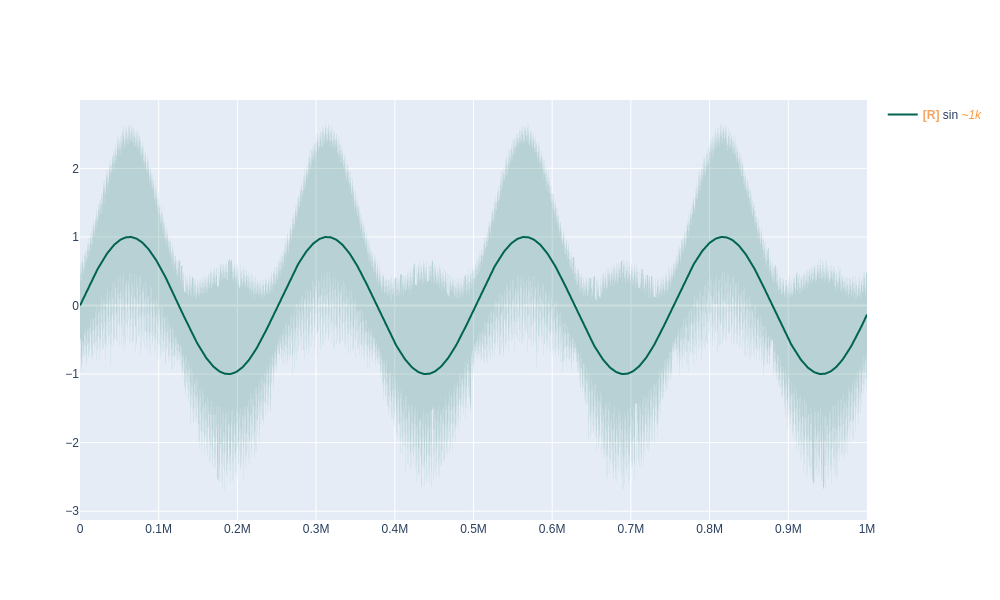

Dash app running on http://127.0.0.1:9018/


In [26]:
# Construct the data
n_vis = 1_000_000
x_vis = np.arange(n_vis) + 1
y_vis = np.sin(x_vis / (n_vis / 25))

# Construct the upper and lower bounds
upper = y_vis + 0.5 + (y_vis) ** 2 + np.random.randn(n_vis) * 0.05
lower = np.min(
    [y_vis - 0.5, y_vis - (abs(y_vis) ** 0.5 + np.random.randn(n_vis) * 0.2)], axis=0
)

# 0. Create the figure
fig = FigureResampler(go.Figure())

# 1.  add the traae
fig.add_trace(go.Scatter(x=x_vis, y=y_vis, line_color="rgb(0,100,80)", name="sin"))

# 2. add the bounds
# NOTE: we use two monotonic increasing traces to fill the area
fig.add_trace(go.Scatter(x=x_vis, y=upper, line_width=0, showlegend=False))
fig.add_trace(
    go.Scatter(
        x=x_vis,
        y=lower,
        line_width=0,
        fill="tonexty",  # fill to the previous trace
        fillcolor="rgba(0,100,80,0.2)",
        showlegend=False,
    )
)

# 3. show the figure
fig.show(renderer="png", width=1000, height=600)
fig.show_dash(mode="external", port=9018)

del x_vis, y_vis, n_vis

## Different downsampler & number of shown samples per trace


To achieve this, you only need to adjust the `max_n_samples` per trace; see the example below


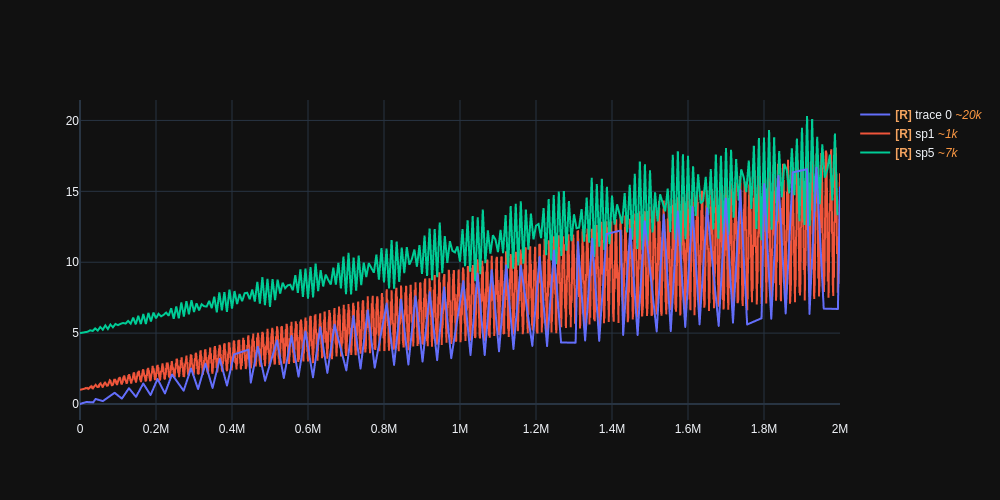

In [27]:
fig = FigureResampler(go.Figure())

fig.add_trace(go.Scattergl(showlegend=True), hf_x=x, hf_y=noisy_sine, max_n_samples=100)
fig.add_trace(dict(x=x, y=noisy_sine + 1, name="sp1"), max_n_samples=2000)
fig.add_trace(
    dict(x=x, y=noisy_sine + 5, name="sp5"),
    max_n_samples=300,
    downsampler=EveryNthPoint(),
)


# Optional: update the layout
fig.update_layout(height=400, template="plotly_dark")

# 2. Call show_dash
fig.show_dash(mode="inline_persistent")

if USE_PNG:
    fig.show(renderer="png", width=1000, height=500)

## Log scale axis


This example utilizes utilzes log x (and y) axis scaling.<br>
We also utilizes [loglTTB](example_utils/loglttb.py), which is a log scale version of the LTTB algorithm.


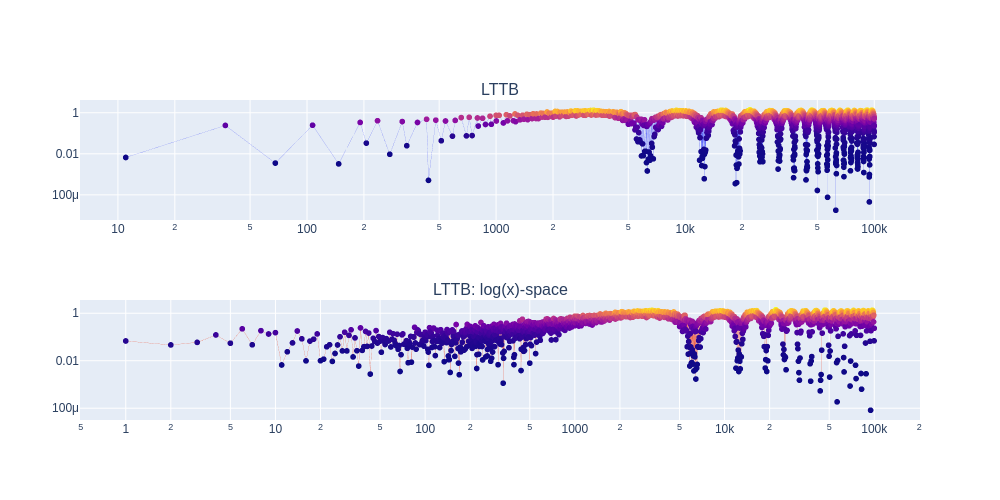

In [28]:
# construct the data
n = 100_000
y = np.abs(np.sin(np.arange(n) / 2_000) + np.random.randn(n) / 10)

fr = FigureResampler(
    make_subplots(rows=2, cols=1, subplot_titles=["LTTB", "LTTB: log(x)-space"])
)
scatter_kwargs = dict(mode="lines+markers", line_width=0.2, showlegend=False)

# Add the first trace, which uses the default downsampler
fr.add_trace(
    go.Scattergl(marker_color=y / np.max(y), **scatter_kwargs),
    hf_y=y,
    max_n_samples=3000,
)

# For the second trace we use a downsampler that works in log-space
from example_utils.loglttb import LogLTTB

fr.add_trace(
    go.Scattergl(marker_color=y / np.max(y), **scatter_kwargs),
    hf_x=np.arange(n),  # NOTE: logLTTB requires x to be passed
    hf_y=y,
    max_n_samples=3000,
    downsampler=LogLTTB(),
    row=2,
    col=1,
)

fr.update_xaxes(type="log")
fr.update_yaxes(type="log")


if USE_PNG:
    fr.show(renderer="png", width=1000, height=500)
else:
    fr.show_dash(mode="inline_persistent")

## Using gap `fill_value=0` and `line_shape='vh` for `fill='tozeroy'`


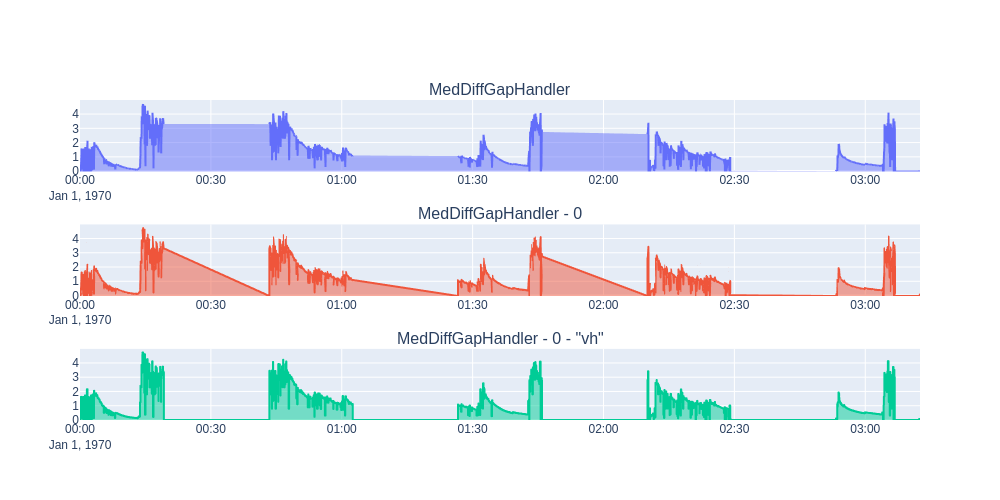

In [29]:
# construct a series in which we will induce some time-gaps
eda_series = pd.read_parquet("data/processed_gsr.parquet")["EDA"]
td_range = eda_series.index[-1] - eda_series.index[0]

# fmt: off
# we repeat the values 10 times to make it more high-frequeny
eda_series = pd.Series(np.repeat(eda_series.values, 10))
index= pd.date_range(start=eda_series.index[0], periods=len(eda_series), freq="25ms").values

# we will insert 4 (equidistant) gaps
for gap_idx in np.linspace(0, len(eda_series), 6)[1:-1]:
    index[int(gap_idx):] +=  pd.Timedelta(seconds= td_range.total_seconds() / 4)
eda_series.index = index

# construct a figure with 3 subplots, each showing different gap handling methods for 
# filled area plots
fr = FigureResampler(
    make_subplots(
        rows=3,
        cols=1,
        subplot_titles=[
            "MedDiffGapHandler",
            "MedDiffGapHandler - 0",
            'MedDiffGapHandler - 0 - "vh"',
        ],
    )
)
fr.add_trace(
    go.Scattergl(fill="tozeroy", showlegend=False),
    hf_x=eda_series.index, hf_y=eda_series.values,
)
fr.add_trace(
    go.Scattergl(fill="tozeroy", showlegend=False),
    hf_x=eda_series.index, hf_y=eda_series.values,
    gap_handler=MedDiffGapHandler(fill_value=0),
    row=2, col=1,
)
fr.add_trace(
    go.Scattergl(fill="tozeroy", showlegend=False, line_shape='vh'),
    hf_x=eda_series.index, hf_y=eda_series.values,
    gap_handler=MedDiffGapHandler(fill_value=0),
    row=3, col=1
)

if USE_PNG:
    fr.show(renderer="png", width=1000, height=500)
else:
    fr.show()

As we can observe in the above figure:

-   The gaps values are introduced at the end of a gap (see difference for `MedDiffGapHandler` and `MedDiffGapHandler - 0`)
-   When using `fill_value=0`, we still need to set the `line_shape='vh'` to obtain no fill for the gap


---


# Various other examples


The visualizations below shows how you plotly-resampler is used for various visualization configurations.


## The example `.gif` from the docs/README


Note how:

-   The example figure withholds both time-indexed data and numeric-indexed data
-   The power-consumption data uses `2,000` samples per trace (`max_n_samples`), whilst the other signals use the default of `1,000` samples per trace.
-   The swimming pool trace uses another downsampling method (`EveryNthPoint`)
-   The swimming pool trace uses `hf_hovertext` which shows the mean # of pool visitors of the last hour.


In [30]:
# ------------ loading the data -----------
df_gusb = pd.read_parquet("data/df_gusb.parquet")
df_data_pc = pd.read_parquet("data/df_pc_test.parquet")

# Create a noisy sine
n = 110_000_00  # 0
x = np.arange(n)
noisy_sine = (3 + np.sin(x / 200_000) + np.random.randn(n) / 10) * x / 100_000

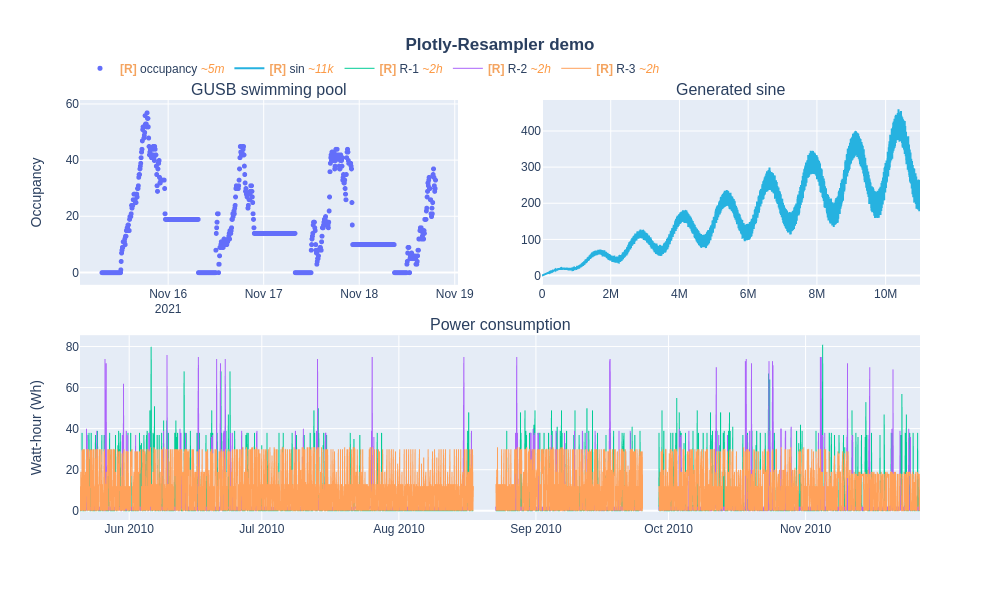

In [31]:
fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=2,
        specs=[[{}, {}], [{"colspan": 2}, None]],
        subplot_titles=("GUSB swimming pool", "Generated sine", "Power consumption"),
        vertical_spacing=0.12,
    ),
    default_n_shown_samples=1000,
    verbose=False,
)


# ------------ swimming pool data -----------
df_gusb_pool = df_gusb["zwembad"].last("4D").dropna()
fig.add_trace(
    go.Scattergl(
        x=df_gusb_pool.index,
        y=df_gusb_pool.astype("uint16"),
        mode="markers",
        marker_size=5,
        name="occupancy",
        # showlegend=False,
    ),
    hf_hovertext="mean last hour: "
    + df_gusb_pool.rolling("1h").mean().astype(int).astype(str),
    downsampler=EveryNthPoint(),
    gap_handler=NoGapHandler(),
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Occupancy", row=1, col=1)


# ----------------- generated sine -----------
fig.add_trace(
    dict(name="sin", line_color="#26b2e0"),
    hf_x=x,
    hf_y=noisy_sine,
    row=1,
    col=2,
)

# ------------- Power consumption data -------------
df_data_pc = df_data_pc.last("190D")
for i, c in enumerate(df_data_pc.columns):
    fig.add_trace(
        go.Scattergl(name=f"R-{i+1}", line_width=1),
        hf_x=df_data_pc.index,
        hf_y=df_data_pc[c],
        max_n_samples=2_000,  # The power consumption data uses 2,000 samples per trace
        row=2,
        col=1,
    )

fig.update_layout(height=650)
fig.update_yaxes(title_text="Watt-hour (Wh)", row=2, col=1)
fig.update_layout(
    title="<b>Plotly-Resampler demo</b>",
    title_x=0.5,
    legend_traceorder="normal",
    legend=dict(orientation="h", y=1.11, xanchor="left", x=0),
)

fig.show_dash(mode="inline_persistent", debug=True, port=9029)

if USE_PNG:
    fig.show(renderer="png", width=1000, height=600)

## Converting a `go.Figure`, with its traces, into a `FigureResampler`


This example first creates the `.gif` figure (with less data, otherwise the graph construction time would be too long) and then uses the `convert_existing_traces` argument of the FigureResampler constructor to convert this into a FigureResampler figure.


In [32]:
from plotly_resampler import unregister_plotly_resampler

unregister_plotly_resampler()

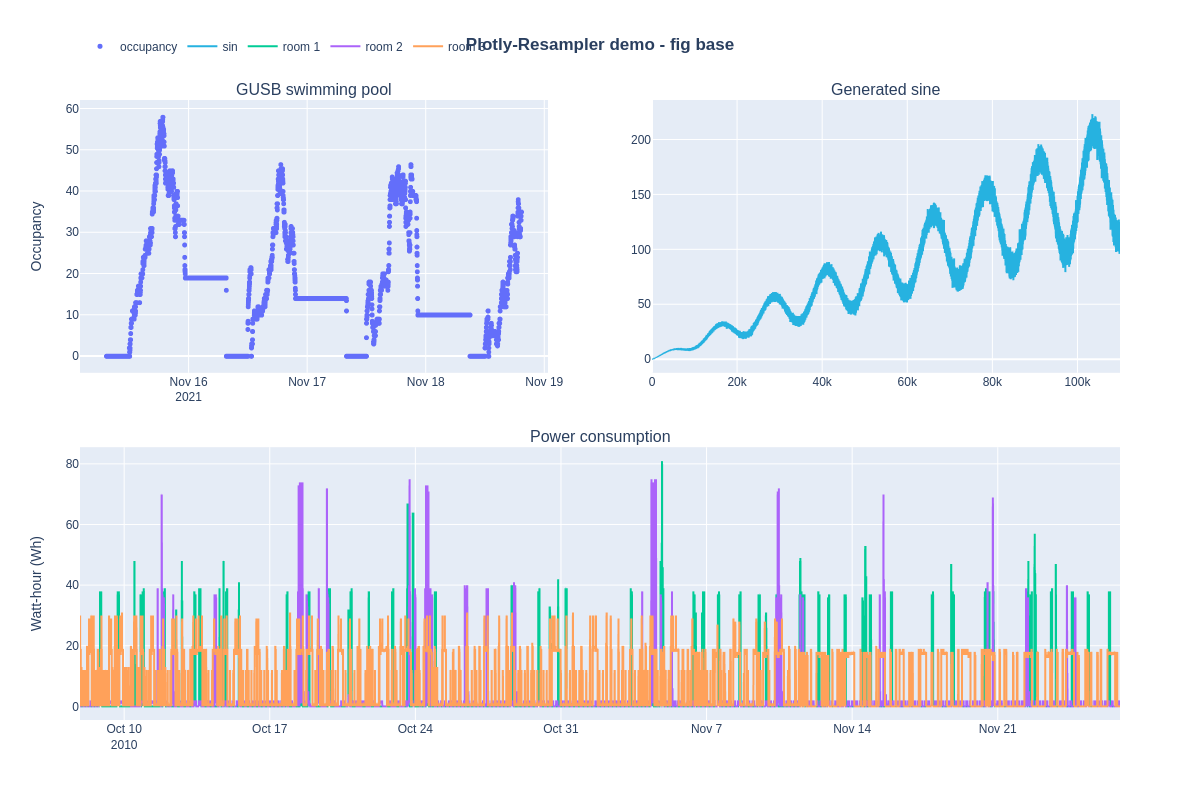

In [33]:
df_gusb = pd.read_parquet(f"data/df_gusb.parquet")
df_data_pc = pd.read_parquet(f"data/df_pc_test.parquet")

n = 110_000
x = np.arange(n)
noisy_sine = (3 + np.sin(x / 2_000) + np.random.randn(n) / 10) * x / 2_000

# construct a normal figure object instead of a figureResample object
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("GUSB swimming pool", "Generated sine", "Power consumption"),
    vertical_spacing=0.12,
)


# ------------ swimming pool data -----------
df_gusb_pool = df_gusb["zwembad"].last("4D").dropna()
fig.add_trace(
    go.Scattergl(
        x=df_gusb_pool.index,
        y=df_gusb_pool,  # .astype("uint16"),
        mode="markers",
        marker_size=5,
        name="occupancy",
        showlegend=True,
        hovertext="mean last hour: "
        + df_gusb_pool.rolling("1h").mean().astype(int).astype(str),
    ),
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Occupancy", row=1, col=1)


# ----------------- generated sine -----------
fig.add_trace(
    go.Scattergl(name="sin", line_color="#26b2e0", x=x, y=noisy_sine),
    row=1,
    col=2,
)

# ------------- Power consumption data -------------
df_data_pc = df_data_pc.last("50D")
for i, c in enumerate(df_data_pc.columns):
    fig.add_trace(
        go.Scattergl(
            name=f"room {i+1}",
            x=df_data_pc.index,
            y=df_data_pc[c],
        ),
        row=2,
        col=1,
    )

fig.update_layout(height=600)
fig.update_yaxes(title_text="Watt-hour (Wh)", row=2, col=1)
fig.update_layout(
    title="<b>Plotly-Resampler demo - fig base</b>",
    title_x=0.5,
    legend_traceorder="normal",
    legend=dict(orientation="h", y=1.11, xanchor="left", x=0),
)
if USE_PNG:
    fig.show(renderer="png", width=1200, height=800)
else:
    fig.show()

Note how the `data` property shape is the raw data size


In [34]:
fig.data[1]["x"].shape

(110000,)

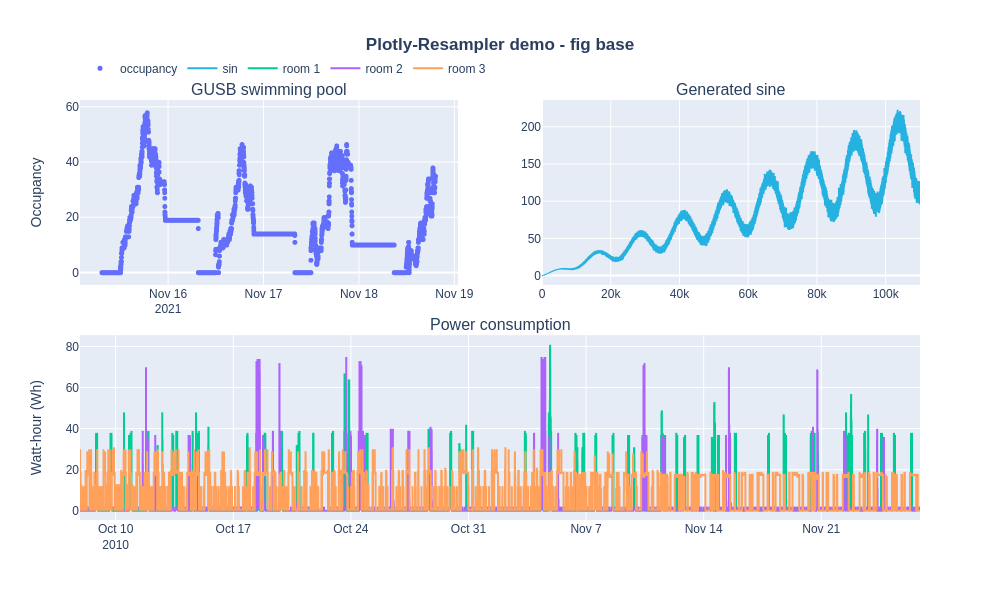

In [35]:
# Convert the figure into a FigurResampler figure by decorating it
fr_fig = FigureResampler(fig, default_n_shown_samples=500, convert_existing_traces=True)
fr_fig.show_dash(mode="inline_persistent")
if USE_PNG:
    fig.show(renderer="png", width=1000, height=600)

In [36]:
print("aggregated data    ", fr_fig.data[1]["x"].shape)
print("raw data (hf_data) ", fr_fig.hf_data[1]["x"].shape)

# The data-shape of the original figure still remains the same
fig.data[1]["x"].shape

aggregated data     (500,)
raw data (hf_data)  (110000,)


(110000,)

**Note**:

-   the data size of `fr_fig` is reduced to `default_n_shown_samples` (_500_) but the original `fig` data is still equal to `110_000`.
-   the raw data can be accessed and altered using the `hf_data` of the FigureResampler object ⬇️


In [37]:
# We flip and take the sqarquere root of the data
fr_fig.hf_data[1]["y"] = -(noisy_sine**2)

# Make sure to interact with he `Generated sine` subplot to see the changes

## Skin conductance example


This example is especially interesting as it **uses a _background-color_ to indicate a signal quality**.

To ensure the consistency of this background color use; we set `gap_handler` to `NoGapHandler` for the signal quality trace its downsampler.


In [38]:
df_gsr = pd.read_parquet("data/processed_gsr.parquet")

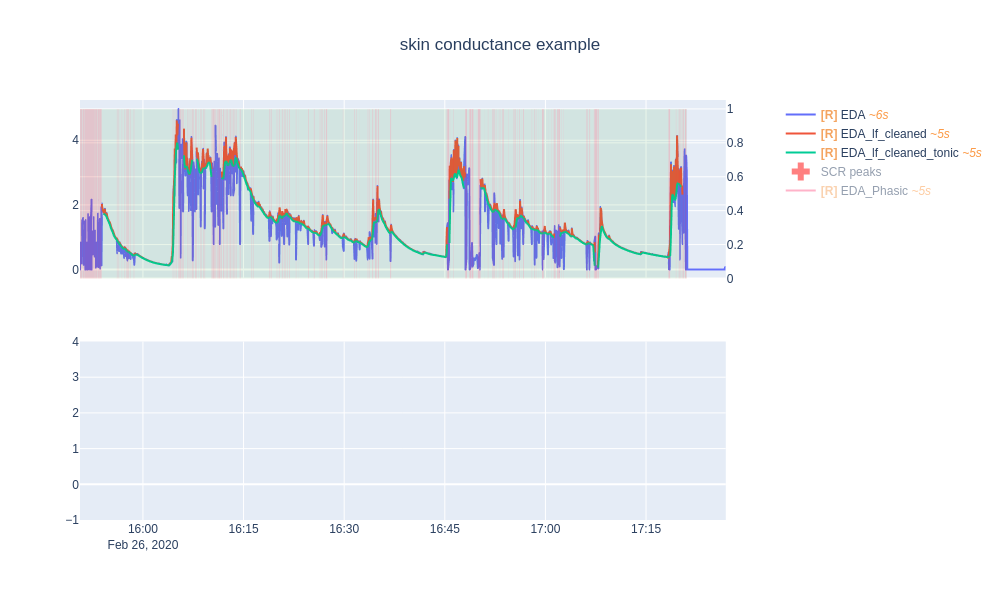

In [39]:
fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=1,
        specs=[[{"secondary_y": True}], [{}]],
        shared_xaxes=True,
    ),
    default_n_shown_samples=1_000,
    verbose=False,
)
fig.update_layout(height=600, title="skin conductance example", title_x=0.5)


# -------------------------------- ROW 1 --------------------------------
# Add the skin conductance signals
for c in ["EDA", "EDA_lf_cleaned", "EDA_lf_cleaned_tonic"]:
    fig.add_trace(go.Scattergl(name=c), hf_x=df_gsr.index, hf_y=df_gsr[c], row=1, col=1)


# Show the Skin Conductance Response Peaks (SCR)
df_peaks = df_gsr[df_gsr["SCR_Peaks_neurokit_reduced_acc"] == 1]
fig.add_trace(
    trace=go.Scattergl(
        x=df_peaks.index,
        y=df_peaks["EDA_lf_cleaned"],
        visible="legendonly",
        mode="markers",
        marker_symbol="cross",
        marker_size=15,
        marker_color="red",
        name="SCR peaks",
    ),
    # Set limit_to_view to true so that the peaks disappear when out-of view-range
    # and thus not disturb the autoscale!!!
    limit_to_view=True,
)


# Display the skin conductance Signal Quality as background
df_grouped = groupby_consecutive(df_gsr["EDA_SQI"])
df_grouped["EDA_SQI"] = df_grouped["EDA_SQI"].map(bool)
df_grouped["good_sqi"] = df_grouped["EDA_SQI"].map(int)
df_grouped["bad_sqi"] = (~df_grouped["EDA_SQI"]).map(int)
for sqi_col, col_or in [
    ("good_sqi", "#2ca02c"),
    ("bad_sqi", "#d62728"),
]:
    fig.add_trace(
        go.Scattergl(
            x=df_grouped["start"],
            y=df_grouped[sqi_col],
            mode="lines",
            line_width=0,
            fill="tozeroy",
            fillcolor=col_or,
            opacity=0.1 if "good" in sqi_col else 0.2,
            line_shape="hv",
            name=sqi_col,
            showlegend=False,
        ),
        # The most important thing here is that we do not interleave gaps
        # Additionally, the limit-to-view also ensures that the autoscale is not
        # disturbed.
        gap_handler=NoGapHandler(),
        limit_to_view=True,
        secondary_y=True,
    )


# -------------------------------- ROW 2 --------------------------------
# show the phasic EDA component
fig.add_trace(
    {"name": "EDA_Phasic", "visible": "legendonly", "type": "scattergl"},
    hf_x=df_gsr.index,
    hf_y=df_gsr["EDA_Phasic"],
    row=2,
    col=1,
)

fig.show_dash(mode="inline_persistent", port=9022)

if USE_PNG:
    fig.show(renderer="png", width=1000, height=600)

## Categorical series - box & histogram


This example highlights how `plotly-resampler` supports combining high-frequency trace-subplots
with non-scatterlike traces such as a histogram & a boxplot.


In [40]:
# Create a categorical series, with mostly a's, but a few sparse b's and c's
cats_list = np.array(list("aaaaaaaaaa" * 1000))
cats_list[np.random.choice(len(cats_list), 100, replace=False)] = "b"
cats_list[np.random.choice(len(cats_list), 50, replace=False)] = "c"
cat_series = pd.Series(
    cats_list,
    dtype="category",
)

_nb_samples = 30_000
x = np.arange(_nb_samples).astype(np.uint32)
y = np.sin(x / 300).astype(np.float32) + np.random.randn(_nb_samples) / 5
float_series = pd.Series(index=x, data=y)

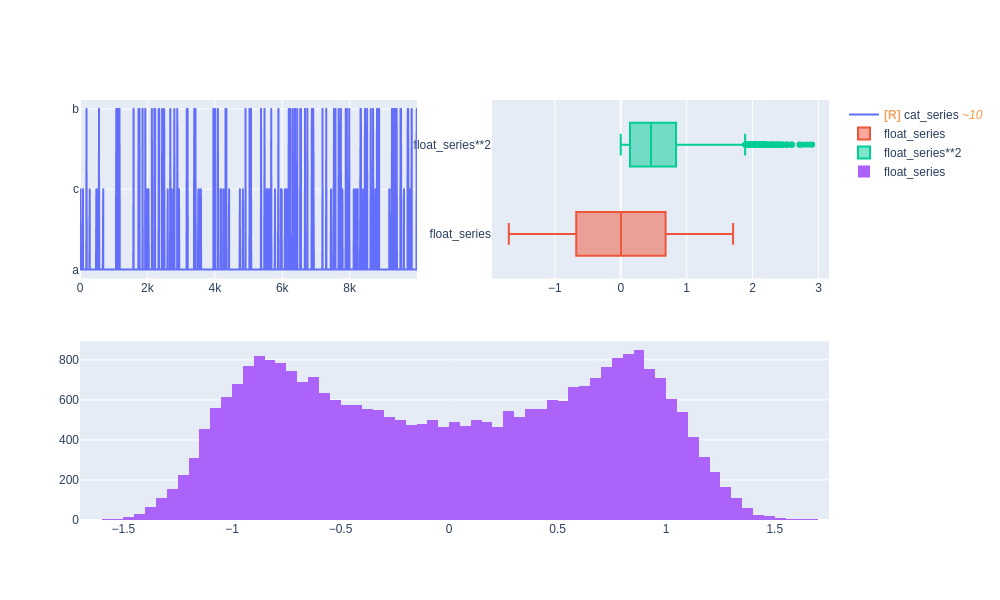

In [41]:
base_fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
)
fig = FigureResampler(base_fig, default_n_shown_samples=1000, verbose=False)

fig.add_trace(
    go.Scattergl(name="cat_series"),
    hf_x=cat_series.index,
    hf_y=cat_series,
    row=1,
    col=1,
    hf_hovertext="text",
)

fig.add_trace(go.Box(x=float_series.values, name="float_series"), row=1, col=2)
fig.add_trace(go.Box(x=float_series.values**2, name="float_series**2"), row=1, col=2)

# add a not hf-trace
fig.add_trace(
    go.Histogram(
        x=float_series,
        name="float_series",
    ),
    row=2,
    col=1,
)
fig.show_dash(mode="inline_persistent", port=9032)

if USE_PNG:
    fig.show(renderer="png", width=1000, height=600)